<a href="https://colab.research.google.com/github/merve215/dogecoin-sentiment-analysis/blob/main/2_3)crypto_subreddit_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Make sure : MyDrive -> Big_Data_Project
!ls /content/drive/MyDrive/Big_Data_Project

Mounted at /content/drive
'0) Converitng to Excels.py'	 'Big Data Project Code.ipynb'	 Price_Data
'1) SubReddits Filtered.ipynb'	 'Big Data Project.gdoc'	 Python_SubReddit_Data
'2-1) doge_anaylsis_part1.py'	 'Crypto Analysis .ipynb'	 reddit2
'2-2)doge_analysis_part2.ipynb'   Lexicon			 SubReddits
 AC2.ipynb			  Output			'Word Cloud.ipynb copy'


In [ ]:
!ls /content/drive/MyDrive/Big_Data_Project
!ls /content/drive/MyDrive/Big_Data_Project/Output

'0) Converitng to Excels.py'	 'Big Data Project Code.ipynb'	 Price_Data
'1) SubReddits Filtered.ipynb'	 'Big Data Project.gdoc'	 Python_SubReddit_Data
'2-1) doge_anaylsis_part1.py'	 'Crypto Analysis .ipynb'	 reddit2
'2-2)doge_analysis_part2.ipynb'   Lexicon			 SubReddits
 AC2.ipynb			  Output			'Word Cloud.ipynb copy'
 crypto_doge_related_posts.csv
 Crypto_doge_related_posts.csv
 dogecoin_posts.csv
 entiredoge_sentiment_results_daily.csv
 firstdoge_analysis_results.csv
 firstdoge_Merged_Sentiment_Results.csv
 firstdoge_Merged_Sentiment_Results_Daily.csv
 investing_doge_related_posts.csv
 investing_doge_related_posts.gsheet
 investing_FinBERT_Sentiment_Results.csv
 investing_Merged_Sentiment_Results.csv
 investing_Merged_Sentiment_Results_Daily.csv
 investing_sentiment_vs_price.png
'normlaized.investing_sentiment_vs_price change.png'
 perf_doge_related_posts.csv
 pf_FinBERT_Sentiment_Results.csv
 pf_Merged_Sentiment_Results_With_Lexicon.csv
 seconddoge_analysis_results.csv
 seconddoge_M

In [ ]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from tqdm import tqdm  # For progress bar

# Data for Investing

In [ ]:
# Load the file
file_path = '/content/drive/MyDrive/Big_Data_Project/Output/investing_doge_related_posts.csv'
df = pd.read_csv(file_path, header=None)


In [ ]:
# Extract text data from column 2 and date data from column 1
texts = df.iloc[:, 1].tolist()
dates = df.iloc[:, 0].tolist()  # Extract date data from column 1

print("\nSample texts:")
for text in texts[:5]:
    print(text)


Sample texts:
2
dogeblin
what are the odds the lught fun hearted " dogecoin" because what ultimately drives a move towards a digial dollar or shall i say currency to pay for everything. it would amaze me if such a simple project ends up dominating so much.
who else is going all in on doge coin?
why it makes sense the market is up about 40% from it's lows


In [ ]:
# Load FinBERT
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')


In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
def predict_sentiment_batch(texts, batch_size=32):

    sentiments = [0, 1, -1]  # 0: neutral, 1: positive, -1: negative
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device) # if we have gpu use gpu else use cpu (gpu much faster)
    model.eval() # Set model to evaluation mode

    # tokenize all at once and use built in dataloader
    dataset = [{"text": text} for text in texts]
    def collate_fn(batch):
        texts = [item['text'] for item in batch]
        return tokenizer(texts, return_tensors="pt", truncation=True, max_length=512, padding=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

    results = []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            # Move batch to the device
            batch = {key: val.to(device) for key, val in batch.items()}
            # Perform inference
            outputs = model(**batch)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
            predicted_classes = torch.argmax(probabilities, dim=1).cpu().numpy()
            probabilities = probabilities.cpu().numpy()
            # Access the original texts from the dataset
            # using the batch index (i) and batch size
            start_index = i * batch_size
            end_index = start_index + batch_size
            # If end index exceeds data set length, then just take the last part of the data set
            if end_index > len(dataset):
              end_index = len(dataset)

            # Get current batch of texts
            batch_texts = [item['text'] for item in dataset[start_index:end_index]]

            # zip together the texts, predictions, and probabilities
            for text, pred, prob in zip(batch_texts, predicted_classes, probabilities):
                # Append the results
                results.append({
                    'text': text,
                    'finbert_sentiment': sentiments[pred],
                    'probabilities': prob.tolist()
                })
    return results

In [ ]:
# Perform batched sentiment analysis
results = predict_sentiment_batch(texts, batch_size=32)

# Add the dates to the results, skipping the first invalid date if it's "1"
for i, result in enumerate(results):
    # Check if the current date is "1" and skip it
    if dates[i] == "1":
        continue
    result['date'] = dates[i]

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Convert the 'date' column to datetime objects, ignoring errors
results_df['date'] = pd.to_datetime(results_df['date'], errors='ignore')
# If the conversion to datetime fails set it to NaT (Not a Time) which is how pandas handles invalid dates
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')

100%|██████████| 14/14 [01:30<00:00,  6.44s/it]
<ipython-input-170-a32b80fabda5>:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  results_df['date'] = pd.to_datetime(results_df['date'], errors='ignore')


In [ ]:
# Save results to a CSV file

output_file = '/content/drive/MyDrive/Big_Data_Project/Output/investing_FinBERT_Sentiment_Results.csv'
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to /content/drive/MyDrive/Big_Data_Project/Output/investing_FinBERT_Sentiment_Results.csv


In [ ]:
# Load additional sentiment lexicon
additional_sentiments_file = '/content/drive/MyDrive/Big_Data_Project/Lexicon/l2_lexicon.csv'
additional_df = pd.read_csv(additional_sentiments_file, header=None, names=['key word', 'sentiment'])  # Specify header=None and names

# Create a dictionary for fast lookup
lexicon_dict = dict(zip(additional_df['key word'], additional_df['sentiment'].map({'neutral': 0, 'positive': 1, 'negative': -1}))) # 0: neutral, 1: positive, -1: negative

In [ ]:
# Apply lexicon-based overrides
def override_with_lexicon(text, finbert_sentiment):
    # Check for matches with lexicon phrases
    for phrase, custom_sentiment in lexicon_dict.items():
        if phrase in text:  # Phrase match found
            return custom_sentiment  # Override sentiment
    return finbert_sentiment  # Use FinBERT sentiment if no match is found

# Apply the lexicon override
# Change 'finbert_results_df' to 'results_df'
results_df['final_sentiment'] = results_df.apply(
    lambda row: override_with_lexicon(row['text'], row['finbert_sentiment']),
    axis=1
)

In [ ]:
# Save final results
output_file = '/content/drive/MyDrive/Big_Data_Project/Output/investing_Merged_Sentiment_Results.csv'
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to /content/drive/MyDrive/Big_Data_Project/Output/investing_Merged_Sentiment_Results.csv


Find average daily sentiment - Investing SubReddit

In [ ]:
import pandas as pd

# Load the final sentiment results
output_file = '/content/drive/MyDrive/Big_Data_Project/Output/investing_Merged_Sentiment_Results.csv'
results_df = pd.read_csv(output_file)

# Convert the 'date' column to datetime objects
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')

# Group by date and calculate the average sentiment for each day
average_daily_sentiment = results_df.groupby('date')['final_sentiment'].mean()

# Print or further process the average daily sentiment
average_daily_sentiment

,final_sentiment
date,
2020-02-21,0.0
2020-04-02,0.0
2020-04-03,0.0
2020-06-08,1.0
2020-07-03,1.0
...,...
2021-12-14,0.0
2021-12-16,0.0
2021-12-22,0.0


In [ ]:
# Define the output file path
output_file = '/content/drive/MyDrive/Big_Data_Project/Output/investing_Merged_Sentiment_Results_Daily.csv'

# Save the average daily sentiment to a CSV file
average_daily_sentiment.to_csv(output_file, header=True)

print(f"Average daily sentiment saved to: {output_file}")

Average daily sentiment saved to: /content/drive/MyDrive/Big_Data_Project/Output/investing_Merged_Sentiment_Results_Daily.csv


# Data for Crypto Subreddit

In [ ]:
# Load the file
file_path = '/content/drive/MyDrive/Big_Data_Project/Output/crypto_doge_related_posts.csv'
df = pd.read_csv(file_path, header=None)

In [ ]:
# Extract text data from column 2 and date data from column 1
texts = df.iloc[:, 1].tolist()
dates = df.iloc[:, 0].tolist()

texts = [str(text) if pd.notnull(text) else "" for text in texts]

print("\nSample texts:")
for text in texts[:5]:
    print(text)



Sample texts:
2
doge weekly prices are trading close to the weekly and critical support, and the downtrend continues to push the price further down. dogecoin prices will t...read more: https://t.co/tvexn5hofy
#btc #doge japanese mathematician shinichi mochizuki of kyoto university has been assumed to be nakamoto in the past. another big name in crypto is elon musk, otherwi...read more: https://t.co/9zycgn52jd
“fire in australia.” by cryptoinline https://link.medium.com/tmwioovjv2 source photos in link. #outline #doge
dogecoin price line falls to $0.00207 after trading with highs placed just below the $0.00226000 mark on the 1-day price chart. 1-day dogecoin price analys...read more: https://t.co/c2vkt1uhb6

Sample texts:
2
doge weekly prices are trading close to the weekly and critical support, and the downtrend continues to push the price further down. dogecoin prices will t...read more: https://t.co/tvexn5hofy
#btc #doge japanese mathematician shinichi mochizuki of kyoto university 

In [ ]:
# FinBERT model
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# sentiment analysis
def predict_sentiment_batch(texts, batch_size=32):
    sentiments = [0, 1, -1]  # 0: neutral, 1: positive, -1: negative
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # model evaluation

    # data prep
    dataset = [{"text": text} for text in texts]

    def collate_fn(batch):
        # extract only text from the batch
        texts = [item['text'] for item in batch]
        # tokenizing
        return tokenizer(texts, return_tensors="pt", truncation=True, max_length=512, padding=True)

    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

    results = []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

            batch = {key: val.to(device) for key, val in batch.items()}

            #inference
            outputs = model(**batch)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
            predicted_classes = torch.argmax(probabilities, dim=1).cpu().numpy()
            probabilities = probabilities.cpu().numpy()


            start_index = i * batch_size
            end_index = min(start_index + batch_size, len(dataset))
            batch_texts = [item['text'] for item in dataset[start_index:end_index]]

            # save
            for text, pred, prob in zip(batch_texts, predicted_classes, probabilities):
                results.append({
                    'text': text,
                    'finbert_sentiment': sentiments[pred],
                    'probabilities': prob.tolist()
                })

    return results

In [ ]:
# sentiment analysis of the batch
results = predict_sentiment_batch(texts, batch_size=32)

# adding data
for i, result in enumerate(results):
    result['date'] = dates[i] if i < len(dates) else None

results_df = pd.DataFrame(results)


results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')


100%|██████████| 830/830 [1:32:22<00:00,  6.68s/it]
<ipython-input-13-6cdffa873908>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')


In [ ]:
# Save results to a CSV file
output_file = '/content/drive/MyDrive/Big_Data_Project/Output/crypto_FinBERT_Sentiment_Results.csv'
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to /content/drive/MyDrive/Big_Data_Project/Output/crypto_FinBERT_Sentiment_Results.csv


In [ ]:
# Load additional sentiment lexicon
additional_sentiments_file = '/content/drive/MyDrive/Big_Data_Project/Lexicon/l2_lexicon.csv'
additional_df = pd.read_csv(additional_sentiments_file, header=None, names=['key word', 'sentiment'])  # Specify header=None and names

# Create a dictionary for fast lookup
lexicon_dict = dict(zip(additional_df['key word'], additional_df['sentiment'].map({'neutral': 0, 'positive': 1, 'negative': -1}))) # 0: neutral, 1: positive, -1: negative

In [ ]:
# Apply lexicon-based overrides
def override_with_lexicon(text, finbert_sentiment):
    # Check for matches with lexicon phrases
    for phrase, custom_sentiment in lexicon_dict.items():
        if phrase in text:  # Phrase match found
            return custom_sentiment  # Override sentiment
    return finbert_sentiment  # Use FinBERT sentiment if no match is found

# Apply the lexicon override
# Change 'finbert_results_df' to 'results_df'
results_df['final_sentiment'] = results_df.apply(
    lambda row: override_with_lexicon(row['text'], row['finbert_sentiment']),
    axis=1
)

In [ ]:
# Save final results
output_file = '/content/drive/MyDrive/Big_Data_Project/Output/crypto_Merged_Sentiment_Results.csv'
results_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

Results saved to /content/drive/MyDrive/Big_Data_Project/Output/crypto_Merged_Sentiment_Results.csv


Find Average Daily Sentiment - Crypto SubReddit

In [ ]:
import pandas as pd

# Load the final sentiment results
output_file = '/content/drive/MyDrive/Big_Data_Project/Output/crypto_Merged_Sentiment_Results.csv'
results_df = pd.read_csv(output_file)

# Convert the 'date' column to datetime objects
results_df['date'] = pd.to_datetime(results_df['date'], errors='coerce')

# Group by date and calculate the average sentiment for each day
average_daily_sentiment = results_df.groupby('date')['final_sentiment'].mean()

# Convert the Series to a DataFrame
average_daily_sentiment = average_daily_sentiment.reset_index()

# Filter the data between 01/01/2021 and 12/31/2021
start_date = '2021-01-01'
end_date = '2021-12-31'
filtered_data = average_daily_sentiment[
    (average_daily_sentiment['date'] >= start_date) &
    (average_daily_sentiment['date'] <= end_date)
]

# Display or save the filtered data
print(filtered_data)

          date  final_sentiment
170 2021-01-01         0.500000
171 2021-01-02         0.107143
172 2021-01-03         0.027778
173 2021-01-04         0.200000
174 2021-01-05         0.250000
..         ...              ...
530 2021-12-27         0.114286
531 2021-12-28        -0.032258
532 2021-12-29         0.111111
533 2021-12-30         0.080000
534 2021-12-31         0.000000

[365 rows x 2 columns]


In [ ]:
# Define the output file path
output_file = '/content/drive/MyDrive/Big_Data_Project/Output/crypto_Merged_Sentiment_Results_Daily.csv'

# Save the average daily sentiment to a CSV file
average_daily_sentiment.to_csv(output_file, header=True)

print(f"Average daily sentiment saved to: {output_file}")

Average daily sentiment saved to: /content/drive/MyDrive/Big_Data_Project/Output/crypto_Merged_Sentiment_Results_Daily.csv


# Pearson Correlation Coefficient

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [ ]:
# Load the sentiment data
sentiment_file = '/content/drive/MyDrive/Big_Data_Project/Output/crypto_Merged_Sentiment_Results_Daily.csv'
crypto_sentiment_df = pd.read_csv(sentiment_file)

# Load the price data
price_file = '/content/drive/MyDrive/Big_Data_Project/Price_Data/returns_doge_price_filtered_2021.csv'
price_df = pd.read_csv(price_file)

In [ ]:
# Ensure 'date' is in datetime format for both datasets
crypto_sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
price_df['date'] = pd.to_datetime(price_df['Date'])

crypto_sentiment_df = crypto_sentiment_df[(crypto_sentiment_df['date'] >= start_date) & (crypto_sentiment_df['date'] <= end_date)]
price_df = price_df[(price_df['date'] >= start_date) & (price_df['date'] <= end_date)]

In [ ]:
# Merge the datasets on the 'date' column
merged_df = pd.merge(crypto_sentiment_df, price_df, on='date')

# Check the merged data
print(merged_df.head())

   Unnamed: 0       date  final_sentiment        Date     Price      Open  \
0         170 2021-01-01         0.500000  2021-01-01  0.005661  0.004666   
1         171 2021-01-02         0.107143  2021-01-02  0.010489  0.005667   
2         172 2021-01-03         0.027778  2021-01-03  0.009850  0.010493   
3         173 2021-01-04         0.200000  2021-01-04  0.009780  0.009845   
4         174 2021-01-05         0.250000  2021-01-05  0.009958  0.009784   

       High       Low     Vol. Change %   Returns  
0  0.005676  0.004606    8.41B   21.33%       NaN  
1  0.014008  0.005553  100.85B   85.27%  0.852853  
2  0.013928  0.009381   71.68B   -6.09% -0.060921  
3  0.011493  0.007623   38.72B   -0.71% -0.007107  
4  0.010319  0.008866   15.37B    1.82%  0.018200  


In [ ]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [ ]:
# Replace infinite values with NaN
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove rows with NaN values in the relevant columns
merged_df.dropna(subset=['final_sentiment', 'Returns'], inplace=True)

# Now, recalculate the Pearson correlation
correlation, p_value = pearsonr(merged_df['final_sentiment'], merged_df['Returns'])
print(f"Pearson Correlation (Sentiment vs Returns): {correlation}")
print(f"p-value: {p_value}")

Pearson Correlation (Sentiment vs Returns): 0.05791439723815566
p-value: 0.2704351267442619


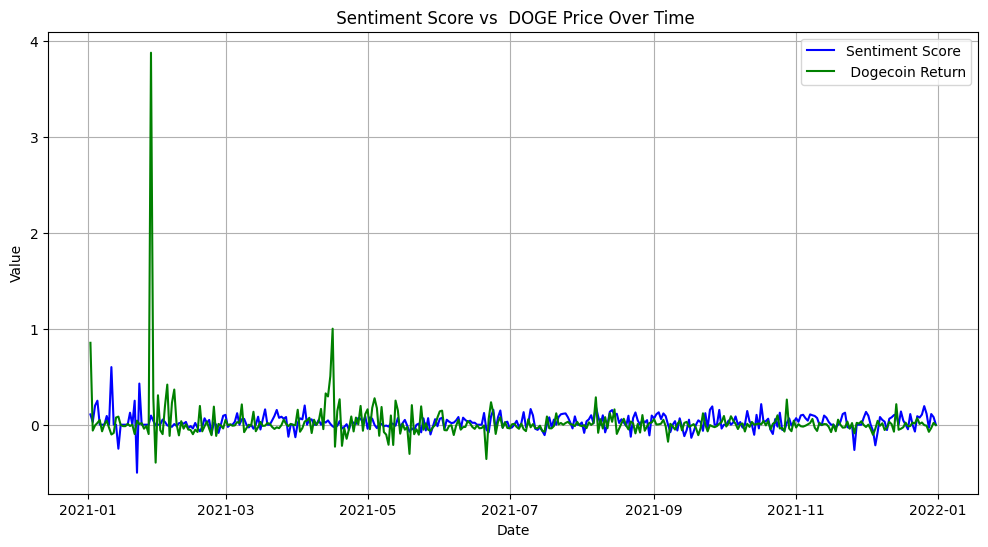

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# nomalizing data
scaler = MinMaxScaler()


# Plotting
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['final_sentiment'], label='Sentiment Score', color='blue')
plt.plot(merged_df['date'], merged_df['Returns'], label=' Dogecoin Return', color='green')
plt.title(" Sentiment Score vs  DOGE Price Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

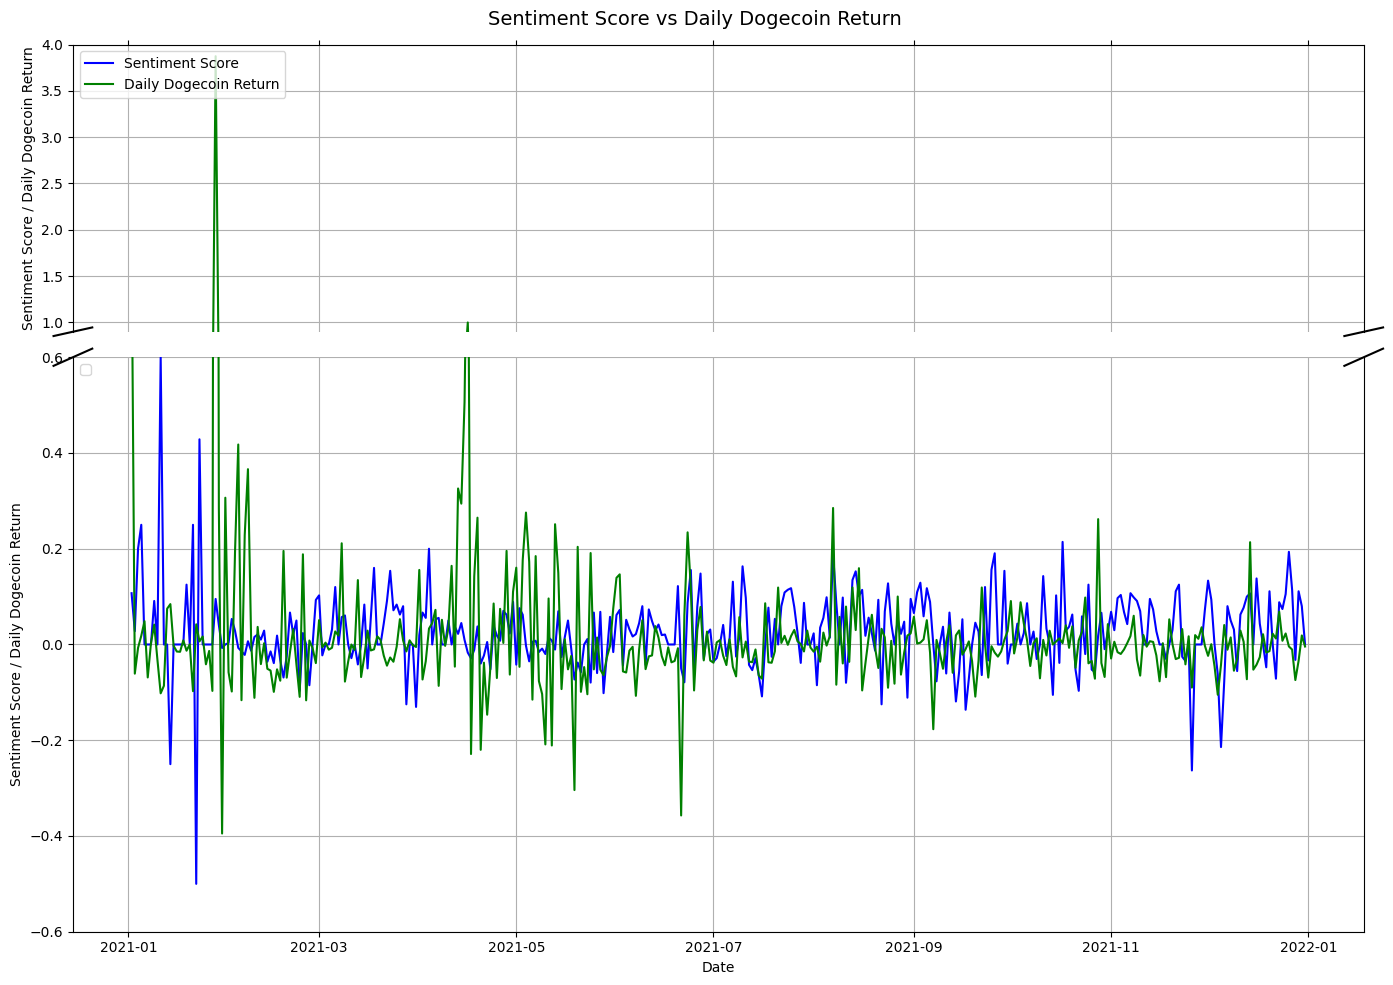

In [ ]:
import matplotlib.pyplot as plt

# Define the figure and subplots with shared x-axis, adjusting relative heights
fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 2]}
)

# Plot Sentiment Score and Daily Dogecoin Return on the first (upper) subplot
ax1.plot(merged_df['date'], merged_df['final_sentiment'], label='Sentiment Score', color='blue')
ax1.plot(merged_df['date'], merged_df['Returns'], label='Daily Dogecoin Return', color='green')
ax1.set_ylabel('Sentiment Score / Daily Dogecoin Return', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0.9, 4)  # Upper range of the shared axis
ax1.legend(loc='upper left')  # Add legend to the upper subplot
ax1.grid()

# Plot Sentiment Score and Daily Dogecoin Return on the second (lower) subplot
ax2.plot(merged_df['date'], merged_df['final_sentiment'], color='blue')
ax2.plot(merged_df['date'], merged_df['Returns'],  color='green')
ax2.set_ylabel('Sentiment Score / Daily Dogecoin Return', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(-0.6, 0.6)  # Lower range of the shared axis
ax2.legend(loc='upper left')  # Add legend to the lower subplot
ax2.grid()

# Hide the spines between the two subplots
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put labels on the top ticks
ax2.xaxis.tick_bottom()

# Add diagonal lines to show the break in the y-axis
d = 0.015  # Diagonal line size
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax2.transAxes)  # Update for bottom plot
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

# Add titles and labels
fig.suptitle('Sentiment Score vs Daily Dogecoin Return', fontsize=14)
ax2.set_xlabel('Date')

plt.tight_layout()
plt.show()


## Adding the Doge SubReddit info

In [ ]:
# Load the crypto sentiment data
sentiment_file = '/content/drive/MyDrive/Big_Data_Project/Output/crypto_Merged_Sentiment_Results_Daily.csv'
crypto_sentiment_df = pd.read_csv(sentiment_file)
crypto_sentiment_df.rename(columns={'final_sentiment': 'crypto_final_sentiment'}, inplace=True)

# Load the price data
price_file = '/content/drive/MyDrive/Big_Data_Project/Price_Data/returns_doge_price_filtered_2021.csv'
price_df = pd.read_csv(price_file)

# Load the Dogesub sentiment data
dogesub_sentiment_file = '/content/drive/MyDrive/Big_Data_Project/Output/entiredoge_sentiment_results_daily.csv'
dogesub_sentiment_df = pd.read_csv(dogesub_sentiment_file)
dogesub_sentiment_df.rename(columns={'final_sentiment': 'dogesub_final_sentiment'}, inplace=True)

# Ensure 'date' is in datetime format for all datasets
crypto_sentiment_df['date'] = pd.to_datetime(crypto_sentiment_df['date'])
dogesub_sentiment_df['date'] = pd.to_datetime(dogesub_sentiment_df['date'])
price_df['date'] = pd.to_datetime(price_df['date'])

# Filter datasets based on the date range (ensure start_date and end_date are defined)
crypto_sentiment_df = crypto_sentiment_df[(crypto_sentiment_df['date'] >= start_date) & (crypto_sentiment_df['date'] <= end_date)]
dogesub_sentiment_df = dogesub_sentiment_df[(dogesub_sentiment_df['date'] >= start_date) & (dogesub_sentiment_df['date'] <= end_date)]
price_df = price_df[(price_df['date'] >= start_date) & (price_df['date'] <= end_date)]

# Merge the datasets on the 'date' column sequentially
merged_df = pd.merge(crypto_sentiment_df, dogesub_sentiment_df, on='date', how='inner')
merged_df = pd.merge(merged_df, price_df, on='date', how='inner')

# Check the merged data
print(merged_df.head())


   Unnamed: 0       date  crypto_final_sentiment  dogesub_final_sentiment  \
0         170 2021-01-01                0.500000                 0.085106   
1         171 2021-01-02                0.107143                 0.005775   
2         172 2021-01-03                0.027778                 0.056944   
3         173 2021-01-04                0.200000                 0.039666   
4         174 2021-01-05                0.250000                 0.052448   

         Date     Price      Open      High       Low     Vol. Change %  \
0  2021-01-01  0.005661  0.004666  0.005676  0.004606    8.41B   21.33%   
1  2021-01-02  0.010489  0.005667  0.014008  0.005553  100.85B   85.27%   
2  2021-01-03  0.009850  0.010493  0.013928  0.009381   71.68B   -6.09%   
3  2021-01-04  0.009780  0.009845  0.011493  0.007623   38.72B   -0.71%   
4  2021-01-05  0.009958  0.009784  0.010319  0.008866   15.37B    1.82%   

    Returns  
0       NaN  
1  0.852853  
2 -0.060921  
3 -0.007107  
4  0.018200  


Below chart illustrates the relationship between the sentiment scores on the doge and crypto subreddits with the daily returns of dogecoin

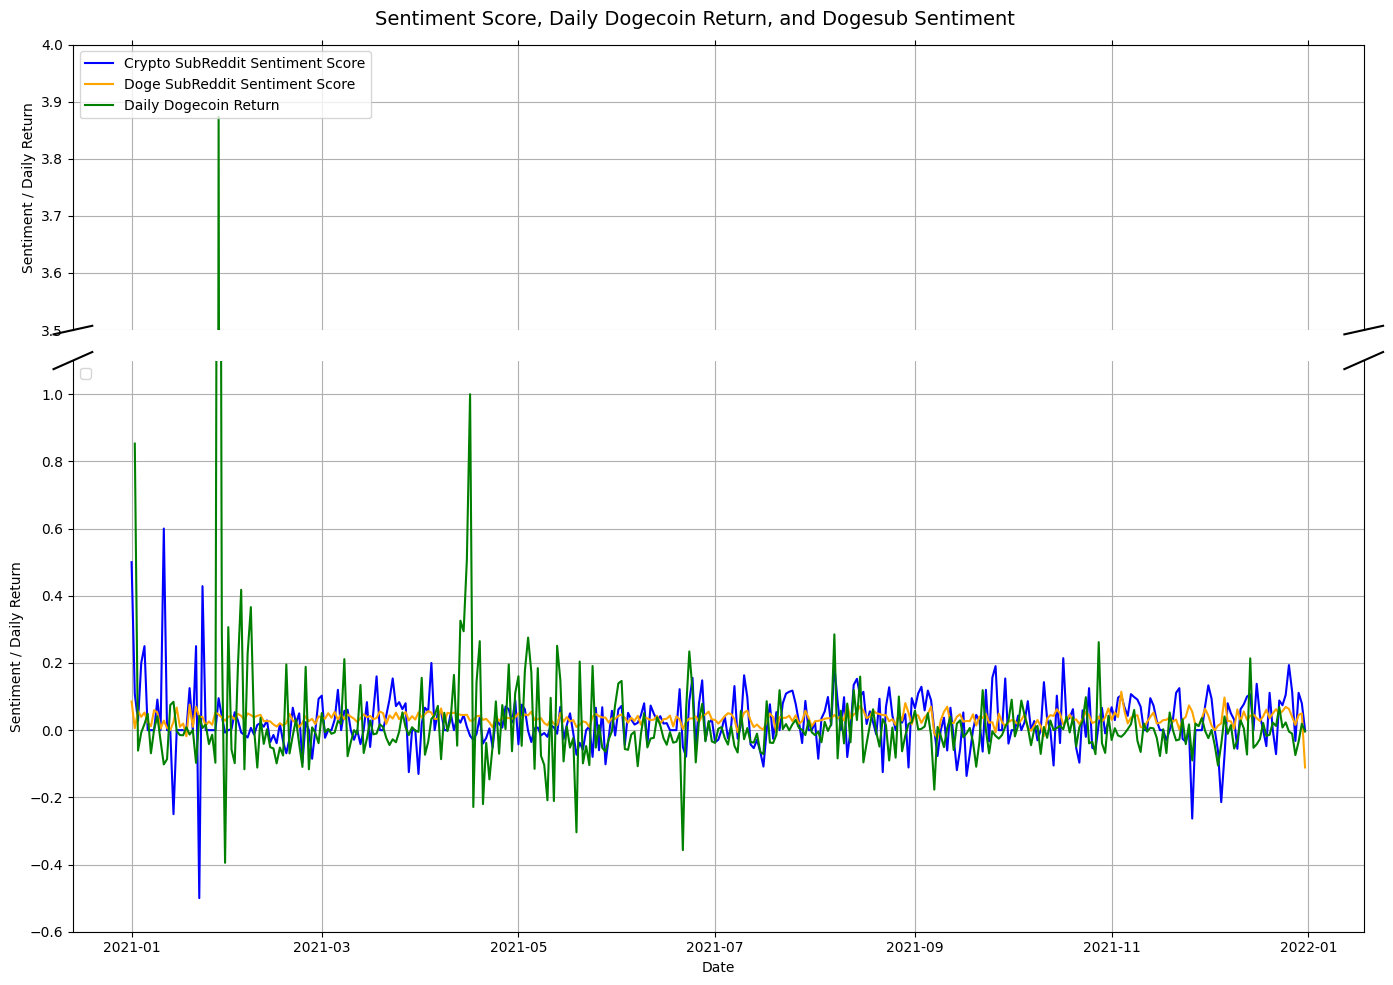

In [ ]:
import matplotlib.pyplot as plt

# Define the figure and subplots with shared x-axis, adjusting relative heights
fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 2]}
)

# Plot Sentiment Score, Daily Dogecoin Return, and Dogesub Sentiment on the first (upper) subplot
ax1.plot(merged_df['date'], merged_df['crypto_final_sentiment'], label='Crypto SubReddit Sentiment Score', color='blue')
ax1.plot(merged_df['date'], merged_df['dogesub_final_sentiment'], label='Doge SubReddit Sentiment Score', color='orange')
ax1.plot(merged_df['date'], merged_df['Returns'], label='Daily Dogecoin Return', color='green')
ax1.set_ylabel('Sentiment / Daily Return', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(3.5, 4)  # Upper range of the shared axis
ax1.legend(loc='upper left')  # Add legend to the upper subplot
ax1.grid()

# Plot Sentiment Score, Daily Dogecoin Return, and Dogesub Sentiment on the second (lower) subplot
ax2.plot(merged_df['date'], merged_df['crypto_final_sentiment'], color='blue')
ax2.plot(merged_df['date'], merged_df['dogesub_final_sentiment'], color='orange')
ax2.plot(merged_df['date'], merged_df['Returns'], color='green')
ax2.set_ylabel('Sentiment / Daily Return', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(-0.6, 1.1)  # Lower range of the shared axis
ax2.legend(loc='upper left')  # Add legend to the lower subplot
ax2.grid()

# Hide the spines between the two subplots
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Don't put labels on the top ticks
ax2.xaxis.tick_bottom()

# Add diagonal lines to show the break in the y-axis
d = 0.015  # Diagonal line size
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax2.transAxes)  # Update for bottom plot
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

# Add titles and labels
fig.suptitle('Sentiment Score, Daily Dogecoin Return, and Dogesub Sentiment', fontsize=14)
ax2.set_xlabel('Date')

plt.tight_layout()
plt.show()
